In [ ]:
%run ../code/init_mooc_nb.ipy
import scipy
import scipy.linalg as sla
from matplotlib import cm


import warnings
warnings.simplefilter("ignore", UserWarning)


sigma0 = np.array([[1, 0], [0, 1]])
sigmax = np.array([[0, 1], [1, 0]])
sigmay = np.array([[0, -1j], [1j, 0]])
sigmaz = np.array([[1, 0], [0, -1]])


def evaluate_on_grid(X, Y, func):
    """ X, Y should be in np.meshgrid form. It's enough for func to work on floats. """
    data = []
    for xx, yy in zip(X, Y):
        row = []
        for i,j in zip(xx, yy):
            row.append(func(i,j))
        data.append(row)
    data = np.array(data)
    data = [np.array(data[:,:,i]) for i in range(np.shape(data)[2])]
    return data


def get_energy_function(A, B, C):
    """ Used for plotting of hexagonal warping. """
    def func(kx, ky):
        matrix = A*(kx**2+ky**2)*sigma0\
        + B*(kx * sigmay - ky * sigmax) \
        + C* 0.5 * ( (kx+1j*ky)**3 + (kx-1j*ky)**3 ) * sigmaz
        return sla.eigh(matrix)[0]
    return func


# Onsite and hoppings matrices used for building BHZ model
def onsite(site, par):
    A1, A2, B1, B2, D1, D2, C, M = par.A1, par.A2, par.B1, par.B2, par.D1, par.D2, par.C, par.M
    return (C + 2 * D1 + 4 * D2) * np.kron(sigma0, sigma0) + (M + 2 * B1 + 4 * B2) * np.kron(sigma0, sigmaz)


def hopx(site1, site2, par):
    A1, A2, B1, B2, D1, D2, C, M = par.A1, par.A2, par.B1, par.B2, par.D1, par.D2, par.C, par.M
    return - D2 * np.kron(sigma0, sigma0) - B2 * np.kron(sigma0, sigmaz) + A2 * 0.5j * np.kron(sigmax, sigmax)


def hopy(site1, site2, par):
    A1, A2, B1, B2, D1, D2, C, M = par.A1, par.A2, par.B1, par.B2, par.D1, par.D2, par.C, par.M
    return - D2 * np.kron(sigma0, sigma0) - B2 * np.kron(sigma0, sigmaz) + A2 * 0.5j * np.kron(sigmay, sigmax)


def hopz(site1, site2, par):
    A1, A2, B1, B2, D1, D2, C, M = par.A1, par.A2, par.B1, par.B2, par.D1, par.D2, par.C, par.M
    return - D1 * np.kron(sigma0, sigma0) - B1 * np.kron(sigma0, sigmaz) + A1 * 0.5j * np.kron(sigmaz, sigmax)


def bhz_slab(L, W, H):
    """A cuboid region of BHZ material with two leads attached.
    
    parameters for leads and scattering region can be defined separately
    """
    lat = kwant.lattice.general(np.identity(3))
    sys = kwant.Builder()
    
    sym = kwant.TranslationalSymmetry((1, 0, 0))
    lead = kwant.Builder(sym)
    
    def shape_lead(pos):
        (x, y, z) = pos
        return (0 <= z < H) and (0 <= y < W)
    
    def shape(pos):
        (x, y, z) = pos
        return (0 <= z < H) and (0 <= y < W) and (0 <= x < L)
    
    def hopping_x(site1, site2, par):
        xt, yt, zt = site1.pos
        xs, ys, zs = site2.pos
        return hopx(site1,site2,par) * np.exp(-0.5j * par.Bz * (xt - xs) * (yt + ys))
    
    # scattering system
    sys[lat.shape(shape, (0,0,0))] = lambda site, par: onsite(site, par.scat) - par.mu * np.eye(4)
    sys[kwant.HoppingKind((1,0,0), lat)] = lambda site1, site2, par: hopping_x(site1, site2, par.scat)
    sys[kwant.HoppingKind((0,1,0), lat)] = lambda site1, site2, par: hopy(site1, site2, par.scat)
    sys[kwant.HoppingKind((0,0,1), lat)] = lambda site1, site2, par: hopz(site1, site2, par.scat)

    # leads
    lead[lat.shape(shape_lead, (0,0,0))] = lambda site, par: onsite(site, par.lead) - par.mu_lead * np.eye(4)
    lead[kwant.HoppingKind((1,0,0), lat)] = lambda site1, site2, par: hopping_x(site1, site2, par.lead)
    lead[kwant.HoppingKind((0,1,0), lat)] = lambda site1, site2, par: hopy(site1, site2, par.lead)
    lead[kwant.HoppingKind((0,0,1), lat)] = lambda site1, site2, par: hopz(site1, site2, par.lead)
    
    # attaching leads
    sys.attach_lead(lead)
    sys.attach_lead(lead.reversed())
    return sys.finalized()

Performing the necessary imports.

from __future__ import division, print_function
import numpy as np
import matplotlib
import kwant

import ipywidgets
from IPython.html.widgets import interact
from ipywidgets import StaticInteract, RangeWidget, DropDownWidget
from IPython.display import display_html
from matplotlib import pyplot as plt

import pfaffian as pf
from edx_components import *



Press this button to show/hide the code used in the notebook:

#Table of Contents
* [Introduction: searching the periodic table for topological materials](#Introduction:-searching-the-periodic-table-for-topological-materials)
* [Conductance of a 3D topological insulator](#Conductance-of-a-3D-topological-insulator)
* [Landau levels](#Landau-levels)
* [Spectroscopy of the surface of a 3D topological insulator](#Spectroscopy-of-the-surface-of-a-3D-topological-insulator)
* [Quasiparticle interference (QPI)](#Quasiparticle-interference-%28QPI%29)
* [The issue of bulk conductivity](#The-issue-of-bulk-conductivity)
* [Hexagonal warping](#Hexagonal-warping)
* [Outlook: from basic science to potential applications](#Outlook:-from-basic-science-to-potential-applications)


### Plan

* Spectroscopy of 3D TI
* Landau levels
* QPI
* The issue of bulk conductivity
* Hexagonal warping

# Introduction: searching the periodic table for topological materials

How do we find a topological insulator? In the first video of today, David Vanderbilt from Rutgers University will tell us more about the material science aspects of topological insulators research.

This is an expertise that no one from the course team has, so pay close attention to it: this material stands apart from the rest.

In [ ]:
MoocVideo("62ZObitJ4DM",  src_location="6.2-intro")

MoocVideo(**{'download_video': 'true', 'display_name': '', 'sub': '62ZObitJ4DM', 'youtube': '1.00:62ZObitJ4DM', 'show_captions': 'true', 'youtube_id_1_0': '62ZObitJ4DM', 'source': 'http://delftxdownloads.tudelft.nl/TOPOCMx-QuantumKnots/TOPOCMx-6.2-intro-video.720.mp4', 'download_track': 'true'})

In the rest of the lecture, we will instead discuss the experimental signatures of 3D topological insulators, similarly to what we did in the previous week for their 2D counterparts.

All the figures showing the experimental data are copyright of the Zahid Hasan lab, Princeton, 2015. They are available under CC-BY-NC-SA 4.0 International license.

# Conductance of a 3D topological insulator

Both the quantum Hall and quantum spin Hall states had striking conductance quantization properties, thanks to the presence of perfectly transmitting one-dimensional transport channels.

The 3D topological insulators do not posses similarly striking conductance properties. In a slab geometry, the surface states contribute with a finite density of propagating states. This density has a minimum at the Dirac point, and we expect the conductance to increase with a roughly hyperbolic shape away if the chemical potential is tuned away from the Dirac point.

This is what is shown in the plot below:

In [ ]:
# Making system

Bz = 0.
mu_lead = 0.7
mu_max = 0.4

L, W, H = 10, 30, 6
sys = bhz_slab(L, W, H)

momenta = np.linspace(-np.pi/3, np.pi/3, 100)

# calculating bands in scat
par_lead = SimpleNamespace(A1=1.0, A2=1.0, B1=1.0, B2=1.0, C=0.0, D1=0., D2=0., M=-1.0, Bz=Bz)
par = SimpleNamespace(lead=par_lead, scat=par_lead, mu_lead=0.0)
bands = kwant.physics.Bands(sys.leads[0], args=[par])
energies_scat = [bands(k) for k in momenta]


# calculating conductance
mus = np.linspace(-mu_max, mu_max, 40)
data = []

par_lead = SimpleNamespace(A1=1.0, A2=1.0, B1=1.0, B2=1.0, C=0.0, D1=0., D2=0., M=-1.0, Bz=0.0)
par_scat = SimpleNamespace(A1=1.0, A2=1.0, B1=1.0, B2=1.0, C=0.0, D1=0., D2=0., M=-1.0, Bz=Bz)

par = SimpleNamespace(lead=par_lead, scat=par_scat, mu_lead=mu_lead)
sys_leads_fixed = sys.precalculate(energy=0.0, args=[par])

for par.mu in mus:    
    smatrix = kwant.smatrix(sys_leads_fixed, energy=0.0, args=[par])
    data.append(smatrix.transmission(1, 0))


    
# making plot
gmax = 8
band_max = 1

def plot(mu):
    # Figures, axes and matplotlib defaults.
    fig, ax = plt.subplots(1,2, figsize=([9.5, 4]), tight_layout=True)
    ax1, ax2 = ax
    ax2.set_color_cycle(['k'])

    # Plotting conductance
    ax1.plot(mus, data, 'r-')
    ax1.plot([mu, mu], [0, gmax], 'b--')
    
    # Plotting bands
    ax2.plot(momenta, energies_scat)
    ax2.plot([-4, 4], [mu, mu], 'k--')
    
    # Setting labels and titles
    ax1.set_xlabel(r'$\mu$')
    ax1.set_ylabel(r'$G\,[e^2/h]$')

    ax2.set_xlabel('$k$')
    ax2.set_ylabel('$E$')
    
    ax1.set_title('conductance')
    ax2.set_title('spectrum')
    
    # Setting ticks
    vals = np.arange(-0.4, 0.8, 0.4)
    ax1.set_xticks(vals)
    ax1.set_xticklabels(["${0}$".format(i) for i in vals])

    vals = range(0, gmax+1, 2)
    ax1.set_yticks(vals)
    ax1.set_yticklabels(["${0}$".format(i) for i in vals])

    vals = np.arange(-2, 2.5, .5)
    ax2.set_yticks(vals)
    ax2.set_yticklabels(["${0}$".format(i) for i in vals])

    ax2.set_xticks([-np.pi/3, 0.0, np.pi/3])
    ax2.set_xticklabels([r'$-\frac{\pi}{3}$', r'$0$', r'$\frac{\pi}{3}$'])

    # Setting limits
    ax1.set_xlim(-mu_max, mu_max)
    ax1.set_ylim(0, gmax)
    
    ax2.set_xlim(-np.pi/3,np.pi/3);
    ax2.set_ylim(-band_max, band_max)
    
    return fig

StaticInteract(lambda mu: plot(.1*mu), mu = RangeWidget(-3, 3, name='mu', default=0, show_range=True))

It is also the behavior that is observed experimentally. Below, you see that the resistance of a 3D TI slab has a maximum as the chemical potential difference between its two top and bottom surfaces is varied.

![](figures/zero_field_Rxx.png)

(copyright Hasan lab, Princeton, see license in the beginning of the chapter)

Note that in such a measurement, you cannot separate contributions of states coming from the different surfaces, or potentially also from the sides or the sample, or even from the bulk - soon we'll discuss this issue in more detail. 

Nevertheless, the observed maximum in resistance corresponds to the minimum in conductance computed just above, and it demonstrates the presence of a Dirac point between the conduction and valence bands.

Overall, the behaviour above is not particularly telling. In graphene, for instance, you would observe the same behavior. The conductance is not sensitive to degeneracies in the electron spectrum in a qualitative way, so just from it we cannot demonstrate that the surface of a 3D TI has a single Dirac cone, unlike graphene which has four. Hence, while the measurement above is a signature of a surface state, it is not a particularly striking one.

Perhaps we will be more lucky with topological signatures of 3D topological insulators, if we look at the Hall conductance?

# Landau levels

In the last chapter, we saw that one single surface of a 3D topological insulator is characterized by a Hall conductance of $ (n+1/2)\, e^2/h$. We also pointed out that there are always two surfaces, say the top and bottom one of a slab, which gives a total Hall conductance of $(2n+1)\,e^2/h$ and makes it hard to observe the half-integer Hall conductance.

You may say - OK, we can live with this and be happy with our $(2n+1)$ sequence. After all, it looks almost as unique as the $(n+1/2)$ sequence. Sure, it does not allow us to see directly the half-integer value, but it gives a step between plateaus which is twice the usual one, and no plateau with $n=0$. After all, measuring *twice* that sequence was a good enough probe for graphene.

So let's look at a Hall conductance measurements performed on a slab of a 3D TI, focusing for instance on the blue trace. 

![](figures/LL_spectroscopy.png)

(copyright Hasan lab, Princeton, see license in the beginning of the chapter)

You see a sequence of plateaus with integer steps of a normal height $e^2/h$. Nothing special. Why did our prediction of a $(2n+1)$ sequence fail? 

The reason is that there is no symmetry at all between top and bottom surfaces, they are really independent. For instance, they might have different doping, and hence be characterized by different values $n_\textrm{top}$ and $n_\textrm{bottom}$ of the Chern integer.

Therefore, rather than observing a sequence $e^2/h\,(2n+1)$, we observe a more conventional sequence given by $e^2/h\,(n_\textrm{top}+n_\textrm{bottom}+1)$, with the usual $e^2/h$ steps between different plateaus.

So, even studying the Landau levels experimentally we do not get a topological signature. But do not despair, luckily there is a much better thing that we can do rather than just measuring conductance: looking at the energy spectrum of the surface states directly.

In [ ]:
question = ("Which control parameter can remove the 0th plateau in the QHE measurement? ")

answers = ["Increasing the magnetic field.",
           "Gate voltage difference (which controls difference in electron density) between the surfaces.",
           "Increasing topological mass.",
           "Adding an in-plane magnetic field."]

explanation = ("Gate voltage difference changes the filling of the individual states without shifting the total density of electrons. "
            "This can therefore shift the plateaus of each surface. Magnetic field and topological mass are part of generating the "
               " $0^{th}$ plateau to begin with so cannot eliminate it. ")

MoocMultipleChoiceAssessment(question=question, answers=answers, correct_answer=1, explanation=explanation)

MoocMultipleChoiceAssessment(**{'display_name': 'Question', 'correct_answer': 1, 'explanation': 'Gate voltage difference changes the filling of the individual states without shifting the total density of electrons. This can therefore shift the plateaus of each surface. Magnetic field and topological mass are part of generating the  $0^{th}$ plateau to begin with so cannot eliminate it. ', 'question': 'Which control parameter can remove the 0th plateau in the QHE measurement? ', 'answers': ['Increasing the magnetic field.', 'Gate voltage difference (which controls difference in electron density) between the surfaces.', 'Increasing topological mass.', 'Adding an in-plane magnetic field.'], 'max_attempts': 2})

# Spectroscopy of the surface of a 3D topological insulator

Amazingly, the surface states of a 3D topological insulator can be directly imaged experimentally using the technique of Angle Resolved Photo Emission Spectroscopy - or, in short, [ARPES](http://en.wikipedia.org/wiki/Angle-resolved_photoemission_spectroscopy).

In ARPES, X-ray photons are shot vertically into a metal surface in order to eject electrons out of it. When this happens, due to energy and momentum conservation, the emitted electrons have the same momentum parallel to the surface that they had in the crystal, and an energy which is related to their band energy in the crystal. Hence, ARPES is the ideal tool to measure the energy dispersion of the surface states of a solid, i.e. $E(k_x, k_y)$ as a function of momenta $\hbar k_x$ and $\hbar k_y$.

Below, we see an example of ARPES spectra for the surface states of a strong topological insulator Bi$_2$ Se$_3$:

![](figures/arpes_fig1.png)

(copyright Hasan lab, Princeton, see license in the beginning of the chapter)

ARPES can only eject electrons - so only occupied states below the Fermi level are visible in the experiment, but of course one can still map out the Fermi surface at different energies by changing the chemical potential in the crystal. In the ARPES results above we see the results for different dopings of the crystal.

This is what we see in the top set of panels in the figure above: changing the chemical potential, the Fermi surface shrinks from a circle to a point, exactly what you would expect for electrons with a Dirac-like dispersion.

While the top panels shows where the occupied states lie in the $(k_x, k_y)$ plane, in the second and third rows we see a cross-section of the energy as a function of momentum, where the Dirac cone is clearly visible, emerging from a bulk valence band filled with electrons.

In [ ]:
question = ("Why do you think ARPES observes surface states even if there is conductance through the bulk?")

answers = ["ARPES can only observe occupied states and therefore bulk conductance is not an issue. ",
           "Since ARPES measures the spectrum in a momentum resolved way, it can separate out surface and bulk states.",
           "ARPES does not measure conductance and therefore bulk electronic states are not an issue.",
        "Since ARPES measures the spectrum in an energy resolved way, it can selectively choose the surface states in the bulk gap."]

explanation = ("The surface states live within the energy gap of the bulk. Since ARPES directly measure $E(k)$, it separates out "
            "surface states from bulk states, which are in different energy ranges. ")

MoocMultipleChoiceAssessment(question=question, answers=answers, correct_answer=3, explanation=explanation)

MoocMultipleChoiceAssessment(**{'display_name': 'Question', 'correct_answer': 3, 'explanation': 'The surface states live within the energy gap of the bulk. Since ARPES directly measure $E(k)$, it separates out surface states from bulk states, which are in different energy ranges. ', 'question': 'Why do you think ARPES observes surface states even if there is conductance through the bulk?', 'answers': ['ARPES can only observe occupied states and therefore bulk conductance is not an issue. ', 'Since ARPES measures the spectrum in a momentum resolved way, it can separate out surface and bulk states.', 'ARPES does not measure conductance and therefore bulk electronic states are not an issue.', 'Since ARPES measures the spectrum in an energy resolved way, it can selectively choose the surface states in the bulk gap.'], 'max_attempts': 2})

# Quasiparticle interference (QPI)

Scanning tunneling microscopy (STM) is another tool to image surface states in a topological insulator. In the process of STM we tunnel electrons into the surface from a metallic tip. In contrast to ARPES, the electrons are not going into free space, so we don't have momentum resolution. On the other hand, we do trade momentum resolution for nearly atomic spatial resolution. We know exactly where exactly on the surface the electron came from.

Tunneling into a uniform surface can tell us a little bit about which orbital on an atom the electrons at a certain energy come from. Otherwise, we'd see a uniform surface, which wouldn't have much information.  We can make things more interesting and, strangely enough, get more information out, by sprinkling some impurities on the surface. The impurities scatter the surface electrons and produce a standing wave pattern on the surface, which depends on the Fermi surface momenta of the electrons at the particular tunneling energy (Note: in this unit we refer to the equal energy surface in momentum space at the tunneling energy as Fermi surface for convenience). The resulting pattern is referred to QPI. Specifically, Fourier transforming the QPI pattern directly maps out the momentum transfer across the Fermi-surface of the surface state. 

Clearly, we can expect to map out some properties of the momentum space scattering on the surface of the topological insulator. 

In the simulation below. we see that the Fourier transform shows an interesting pattern: 

![](figures/QPI_pic_adapted.png)
(adapted, copyright Hasan lab, Princeton, see license in the beginning of the chapter)  

By comparing the QPI patterns showing spin-dependent and spin-independent scattering (respectively on the left and right column on the right side of the arrow), we see that the intensity at momenta connecting opposite points on the Fermi surface is suppressed in the case of spin-independent scattering.

In fact, by comparing the fourier transform of the QPI on the right with the Fermi surface on the left, we begin to see that the absence of back-scattering, which is one of the key properties of the topological insulator surface state plays a key role. As you might remember from the quantum spin hall systems - elastic backscattering of electrons is forbidden between states at $\bf k$ and $-\bf k$ because of Kramers' theorem. Looking at the QPI pattern from spin-independent impurities and comparing it with the Fermi surface confirms this. 

# The issue of bulk conductivity

One of the central issues that has plagued the experimental progress with topological insulators is the presence of bulk doping or conductance in most naturally grown crystals. You can see this simply by looking at the ARPES plots below:

![](figures/bulk_conductance_TI.png)
(copyright Hasan lab, Princeton, see license in the beginning of the chapter)

What you see is that the Fermi-energy, which is the highest energy till which you can eject electrons in ARPES intersects the conduction band. This means that in the native state the conduction band of the electrons is occupied and the fermi level is not in the gap. This problem is terrible on the panel in the extreme left for pure Antimony, which is really a semimetal with overlapping electron and hole bands. In this case, independent of where the fermi level is the system would remain metallic. Moving from pure Sb to $Bi_2 Se_3$ improves this somewhat, but still does not make this an insulator. Theoretically, we do expect pure $Bi_2 Se_3$ to be an insulator - on the other hand, the system typically appears to have Se vacancies, which make the system metallic.

Being metallic really ruins a lot of the interesting properties of topological insulators. So a lot of effort is going in to fixing it up. Below, we see some of the results from these attempts:

![](figures/insulating_TI.png)
(copyright Hasan lab, Princeton, see license in the beginning of the chapter)

where various combinations of $Bi$, $Se$ and $Te$ have been combined to drive the system insulating. By looking at the ARPES spectra, it should look convincing that by varying different conditions, the fermi level is indeed shifting in to the interior of the gap. The experimental tricks used to get this working range between changing the pressure of various elements in the growth condition to counter doping the surface etc.  But the resistance results seem to be improving quite a bit.

# Hexagonal warping

ARPES measurements on the surface of topological materials in the bismuth family also demonstrated an interesting (even though non-topological) feature of the surface states.

The effective Dirac Hamiltonian is linear in momentum and has a full rotational symmetry in the $(x,y)$ plane of the surface, making the Fermi surface circular. However, moving away in energy from the Dirac point, experimentalists observed a different shape of the Fermi surface, similar to a snowflake:

![](figures/warping.png)
(copyright Hasan lab, Princeton, see license in the beginning of the chapter)

It's clear that this shape cannot be explained by the Dirac Hamiltonian with its rotational invariance. In order to take into account this deformation of the Fermi surface, we have to think about the crystal symmetries of the surface. In BiSe and BiTe compounds, there is no full rotational symmetry, but only a lower three-fold rotation symmetry. We can take into account this effect by adding a correction to the effective Dirac Hamiltonian.

This is exactly what was done in this article:

In [ ]:
PreprintReference("0908.1418", show_abstract=False)

There Liang Fu made a relatively simple theoretical exercise. He listed all the terms in the Hamiltonian allowed by time-reversal and crystalline symmetries, that are are proportional to $k^3$. This is the result:

$$
H(\mathbf{k}) = E_0(k) + v\, (1+\alpha \mathbf{k}^2)\,(k_x\sigma_y - k_y\sigma_x) + \frac{\lambda}{2}\,(k^3_++k^3_-)\,\sigma_z
$$

You see a correction to the Dirac velocity proportional to $\alpha \mathbf{k}^2$, which doesn't break the rotational symmetry, as well as the term with $\lambda$, which is responsible for the warping.

Let's plot the spectrum of this extended effective Hamiltonian:

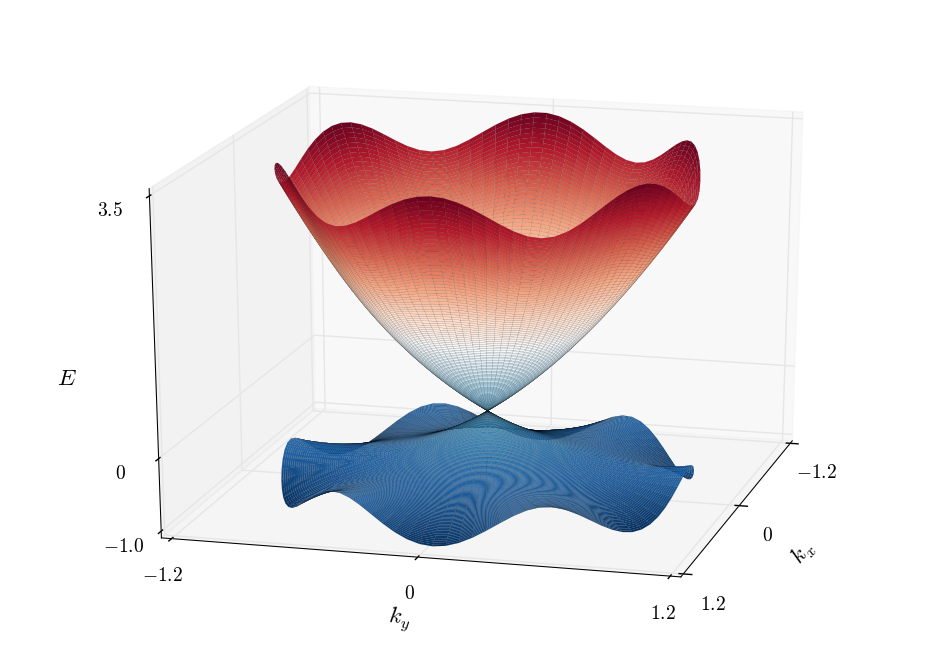

In [ ]:
def plot_warping(A=0.0, B=1.0, C=1.0, Kmax=0.2):
    # Plot parameters
    N = 100
    xlim, ylim = 1.2, 1.2
    zmin, zmax = -1.0, 3.5
    
    r = np.linspace(0,Kmax,N)
    p = np.linspace(0,2*np.pi,N)
    
    R,P = np.meshgrid(r,p)
    X,Y = R*np.cos(P),R*np.sin(P)
    energies = evaluate_on_grid(X, Y, func=get_energy_function(A, B, C))

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    vmin = np.array(energies).min()
    vmax = np.array(energies).max()
    
    for z in energies:
        ax.plot_surface(X, Y, z, rstride=1, cstride=1, cmap=cm.RdBu_r, linewidth=0.05, vmin=vmin, vmax=vmax)
    
    ax.set_xlabel('$k_x$')# [\sqrt{v/\lambda}]$')
    ax.set_ylabel('$k_y$')# [\sqrt{v/\lambda}]$')
    ax.set_zlabel('$E$')# [E^{*}]$')
      
    ax.set_xlim3d(-xlim, xlim)
    ax.set_ylim3d(-ylim, ylim)
    ax.set_zlim3d(zmin, zmax)
    
    vals = [-xlim,0,xlim]
    ax.set_xticks(vals)
    ax.set_xticklabels(["${0}$".format(i) for i in vals])

    vals = [-ylim,0,ylim]
    ax.set_yticks(vals)
    ax.set_yticklabels(["${0}$".format(i) for i in vals])

    
    vals = [zmin, 0, zmax]
    ax.set_zticks(vals)
    ax.set_zticklabels(["${0}$".format(i) for i in vals])
    
    ax.view_init(20,15)
    
    return ax

plot_warping(A=1.2, B=1.8, C=1.5, Kmax=1.0);

This Hamiltonian reproduces correctly the *hexagonal warping* of the Fermi surface. In particular, independently of the parameters $\lambda$ and $\alpha$, the vertices of the hexagon are always aligned with the $x$ crystal axis, as is observed experimentally.

In addition to modifying the shape of the Fermi surface, we see that the extra term is proportional to $\sigma_z$, and rotates the spin of the surface state out of plane. This strongly affects the scattering properties properties of the surface state.

# Outlook: from basic science to potential applications

David Vanderbilt will conclude this week's lectures by offering a perspective on the future of the field.

In [ ]:
MoocVideo("WZmNeEwM1N4",  src_location="6.2-summary")

MoocVideo(**{'download_video': 'true', 'display_name': '', 'sub': 'WZmNeEwM1N4', 'youtube': '1.00:WZmNeEwM1N4', 'show_captions': 'true', 'youtube_id_1_0': 'WZmNeEwM1N4', 'source': 'http://delftxdownloads.tudelft.nl/TOPOCMx-QuantumKnots/TOPOCMx-6.2-summary-video.720.mp4', 'download_track': 'true'})

In [ ]:
MoocDiscussion("Questions", "3DTI materials and signatures")

MoocDiscussion(**{'discussion_category': 'Questions', 'discussion_target': '3DTI materials and signatures', 'display_name': '3DTI materials and signatures', 'discussion_id': '099ba034a0ba28eaf675262c8749b797'})